## **Data Preprocessing**

In [ ]:
import numpy as np
import pandas as pd
import torch
import random


from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DL_HW4/nvda.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


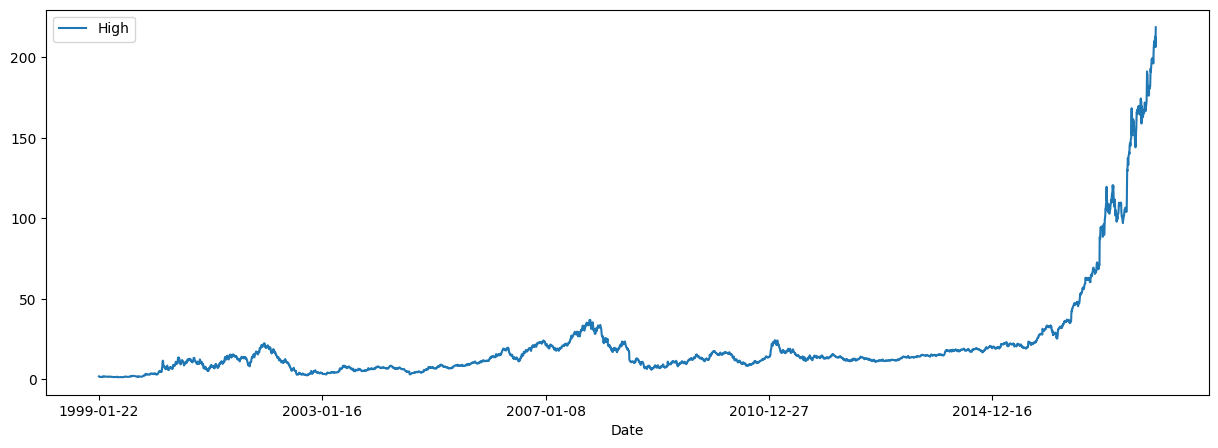

In [ ]:
plot = df.plot('Date', 'High', figsize=(15, 5))

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


In [ ]:
# checking for null values
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
OpenInt,0


In [ ]:
df = df.dropna()

In [ ]:
df.shape

(4733, 7)

## **3 combinations of window size & step**

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

def run_experiment(df, window_size, step, with_volume=False, seed=42):
    # 設定隨機種子
    np.random.seed(seed)
    torch.manual_seed(seed)
    import random
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # 特徵選擇
    if with_volume:
        features = df[['Open', 'High', 'Low', 'Close', 'Volume']]
        input_dim = 5
    else:
        features = df[['Open', 'High', 'Low', 'Close']]
        input_dim = 4
    labels = df['High'].shift(-1).dropna()
    features = features.iloc[:-1]

    # 建立序列
    def create_sequences(input_data, output_data, window_size, step):
        sequences, labels = [], []
        for i in range(0, len(input_data) - window_size, step):
            sequences.append(input_data[i:(i + window_size)])
            labels.append(output_data[i + window_size])
        return np.array(sequences), np.array(labels)

    X, y = create_sequences(features.values, labels.values, window_size, step)

    # 測試集切分（10%）
    ind = np.linspace(0, len(X) - 1, num=int(len(X) * 0.1), dtype=int)
    x_test_raw, y_test = X[ind], y[ind]
    X, y = np.delete(X, ind, axis=0), np.delete(y, ind, axis=0)

    # 資料切分
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]
    split = int(len(X) * 0.8)
    x_train_raw, y_train = X[:split], y[:split]
    x_val_raw, y_val = X[split:], y[split:]

    # 轉換為 Tensor（不做 normalization）
    x_train = torch.from_numpy(x_train_raw).float()
    y_train = torch.from_numpy(y_train).float()
    x_val = torch.from_numpy(x_val_raw).float()
    y_val = torch.from_numpy(y_val).float()
    x_test = torch.from_numpy(x_test_raw).float()
    y_test = torch.from_numpy(y_test).float()

    # 資料載入器
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=32)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=32)

    # LSTM 模型
    class LSTMModel(nn.Module):
        def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
            super().__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            out, _ = self.lstm(x)
            return self.fc(out[:, -1, :])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(input_dim=input_dim, hidden_dim=500, num_layers=1, output_dim=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = CosineAnnealingLR(optimizer, T_max=100)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    for epoch in range(100):
        model.train()
        total_loss=0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features).squeeze(-1)
                val_loss += criterion(outputs, labels).item()
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        print(f'Epoch {epoch+1}/100, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # 測試
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            pred = model(features).squeeze(-1).cpu()
            preds.append(pred)
            actuals.append(labels)
    pred_value = torch.cat(preds).numpy()
    actual_value = torch.cat(actuals).numpy()

    # MSE 計算
    test_mse = np.mean((pred_value - actual_value) ** 2)
    return round(test_mse, 6)


In [ ]:
params = [
    (10, 5),   # window > step
    (10, 10),  # window = step
    (5, 10)    # window < step
]
results = []

for w, s in params:
    mse = run_experiment(df, window_size=w, step=s, with_volume=False)
    results.append({'Window Size': w, 'Step Size': s, 'MSE (Raw Input)': mse})

import pandas as pd
pd.DataFrame(results)


Epoch 1/100, Train loss: 1150.2249, Val loss: 693.2274, Best Val loss: 693.2274
Epoch 2/100, Train loss: 879.0414, Val loss: 570.8699, Best Val loss: 570.8699
Epoch 3/100, Train loss: 908.0383, Val loss: 494.7178, Best Val loss: 494.7178
Epoch 4/100, Train loss: 748.1249, Val loss: 429.6195, Best Val loss: 429.6195
Epoch 5/100, Train loss: 658.2494, Val loss: 378.7449, Best Val loss: 378.7449
Epoch 6/100, Train loss: 493.6470, Val loss: 332.2879, Best Val loss: 332.2879
Epoch 7/100, Train loss: 479.4180, Val loss: 297.6078, Best Val loss: 297.6078
Epoch 8/100, Train loss: 424.8443, Val loss: 265.7236, Best Val loss: 265.7236
Epoch 9/100, Train loss: 339.5275, Val loss: 237.7978, Best Val loss: 237.7978
Epoch 10/100, Train loss: 299.0137, Val loss: 212.2130, Best Val loss: 212.2130
Epoch 11/100, Train loss: 273.6637, Val loss: 192.3648, Best Val loss: 192.3648
Epoch 12/100, Train loss: 240.1963, Val loss: 170.6134, Best Val loss: 170.6134
Epoch 13/100, Train loss: 212.0147, Val loss: 15

,Window Size,Step Size,MSE (Raw Input)
0,10,5,17.669674
1,10,10,159.790543
2,5,10,161.606033


## **加入Volume欄位**

In [ ]:
params = [
    (10, 5),   # window > step
    (10, 10),  # window = step
    (5, 10)    # window < step
]
results = []

for w, s in params:
    mse = run_experiment(df, window_size=w, step=s, with_volume=True)
    results.append({'Window Size': w, 'Step Size': s, 'MSE (Raw Input)': mse})

import pandas as pd
pd.DataFrame(results)


Epoch 1/100, Train loss: 1400.4708, Val loss: 961.2421, Best Val loss: 961.2421
Epoch 2/100, Train loss: 1254.8013, Val loss: 892.3381, Best Val loss: 892.3381
Epoch 3/100, Train loss: 1186.7337, Val loss: 837.7018, Best Val loss: 837.7018
Epoch 4/100, Train loss: 1128.8326, Val loss: 794.5156, Best Val loss: 794.5156
Epoch 5/100, Train loss: 1136.4621, Val loss: 762.5956, Best Val loss: 762.5956
Epoch 6/100, Train loss: 1042.2740, Val loss: 736.0078, Best Val loss: 736.0078
Epoch 7/100, Train loss: 1116.0006, Val loss: 719.9597, Best Val loss: 719.9597
Epoch 8/100, Train loss: 988.4147, Val loss: 706.1372, Best Val loss: 706.1372
Epoch 9/100, Train loss: 971.5909, Val loss: 697.8559, Best Val loss: 697.8559
Epoch 10/100, Train loss: 1145.4332, Val loss: 692.9116, Best Val loss: 692.9116
Epoch 11/100, Train loss: 951.4209, Val loss: 689.6803, Best Val loss: 689.6803
Epoch 12/100, Train loss: 943.0079, Val loss: 688.3216, Best Val loss: 688.3216
Epoch 13/100, Train loss: 1008.7102, Val 

,Window Size,Step Size,MSE (Raw Input)
0,10,5,1105.132812
1,10,10,1378.377197
2,5,10,1365.297241


## **Normalized input**

In [ ]:
def run_experiment_normalize(df, window_size, step, with_volume=False, seed=42):
    # 🔒 Set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # 🔺 Feature selection
    if with_volume:
        features = df[['Open', 'High', 'Low', 'Close', 'Volume']]
        input_dim = 5
    else:
        features = df[['Open', 'High', 'Low', 'Close']]
        input_dim = 4

    labels = df['High'].shift(-1).dropna()
    features = features.iloc[:-1]

    # Create sequences
    X, y = create_sequences(features.values, labels.values, window_size, step)

    # Test set split
    ind = np.linspace(0, len(X) - 1, num=int(len(X) * 0.1), dtype=int)
    x_test_raw, y_test = X[ind], y[ind]
    X, y = np.delete(X, ind, axis=0), np.delete(y, ind, axis=0)

    # Shuffle & train/val split
    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]
    split = int(len(X) * 0.8)
    x_train_raw, y_train = X[:split], y[:split]
    x_val_raw, y_val = X[split:], y[split:]

    # Scaling
    scaler_x = MinMaxScaler().fit(x_train_raw.reshape(-1, x_train_raw.shape[-1]))
    x_train = scaler_x.transform(x_train_raw.reshape(-1, x_train_raw.shape[-1])).reshape(x_train_raw.shape)
    x_val = scaler_x.transform(x_val_raw.reshape(-1, x_val_raw.shape[-1])).reshape(x_val_raw.shape)
    x_test = scaler_x.transform(x_test_raw.reshape(-1, x_test_raw.shape[-1])).reshape(x_test_raw.shape)

    scaler_y = MinMaxScaler().fit(y_train.reshape(-1, 1))
    y_train = scaler_y.transform(y_train.reshape(-1, 1)).reshape(-1)
    y_val = scaler_y.transform(y_val.reshape(-1, 1)).reshape(-1)
    y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)

    # Tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).float()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()

    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=32)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=32)

    # Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(input_dim=input_dim, hidden_dim=500, num_layers=1, output_dim=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=100)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(100):
        model.train()
        total_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        lr_scheduler.step()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features).squeeze(-1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        print(f'Epoch {epoch+1:03} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {avg_val_loss:.4f}')

    # Test
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            pred = model(features).squeeze(-1).cpu()
            preds.append(pred)
            actuals.append(labels)
    pred_value = torch.cat(preds)
    actual_value = torch.cat(actuals)

    pred_real = scaler_y.inverse_transform(pred_value.numpy().reshape(-1, 1)).reshape(-1)
    actual_real = scaler_y.inverse_transform(actual_value.numpy().reshape(-1, 1)).reshape(-1)
    test_mse = np.mean((pred_real - actual_real) ** 2)
    return round(test_mse, 6)


In [ ]:
params = [
    (10, 5),   # window > step
    (10, 10),  # window = step
    (5, 10)    # window < step
]
results = []

for w, s in params:
    mse = run_experiment_normalize(df, window_size=w, step=s, with_volume=False)
    results.append({'Window Size': w, 'Step Size': s, 'MSE (Normalize Input)': mse})

import pandas as pd
pd.DataFrame(results)

Epoch 001 | Train Loss: 0.0132 | Val Loss: 0.0081
Epoch 002 | Train Loss: 0.0087 | Val Loss: 0.0013
Epoch 003 | Train Loss: 0.0018 | Val Loss: 0.0011
Epoch 004 | Train Loss: 0.0005 | Val Loss: 0.0002
Epoch 005 | Train Loss: 0.0002 | Val Loss: 0.0001
Epoch 006 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 007 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 008 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 009 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 010 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 011 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 012 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 013 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 014 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 015 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 016 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 017 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 018 | Train Loss: 0.0001 | Val Loss: 0.0002
Epoch 019 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 020 | Train Loss: 0.0001 | Val Loss: 0.0001


,Window Size,Step Size,MSE (Normalize Input)
0,10,5,0.760277
1,10,10,1.420198
2,5,10,2.604735


## **Different Feature Combinations**

In [ ]:
def run_experiment_normalize_custom(df, window_size, step, feature_cols, seed=42):
    # Set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    import random
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Feature selection
    features = df[feature_cols].copy()
    input_dim = features.shape[1]
    labels = df['High'].shift(-1).dropna()
    features = features.iloc[:-1]

    # Sequence
    X, y = create_sequences(features.values, labels.values, window_size, step)
    ind = np.linspace(0, len(X) - 1, num=int(len(X) * 0.1), dtype=int)
    x_test_raw, y_test = X[ind], y[ind]
    X, y = np.delete(X, ind, axis=0), np.delete(y, ind, axis=0)

    idx = np.random.permutation(len(X))
    X, y = X[idx], y[idx]
    split = int(len(X) * 0.8)
    x_train_raw, y_train = X[:split], y[:split]
    x_val_raw, y_val = X[split:], y[split:]

    scaler_x = MinMaxScaler().fit(x_train_raw.reshape(-1, input_dim))
    x_train = scaler_x.transform(x_train_raw.reshape(-1, input_dim)).reshape(x_train_raw.shape)
    x_val = scaler_x.transform(x_val_raw.reshape(-1, input_dim)).reshape(x_val_raw.shape)
    x_test = scaler_x.transform(x_test_raw.reshape(-1, input_dim)).reshape(x_test_raw.shape)

    scaler_y = MinMaxScaler().fit(y_train.reshape(-1, 1))
    y_train = scaler_y.transform(y_train.reshape(-1, 1)).reshape(-1)
    y_val = scaler_y.transform(y_val.reshape(-1, 1)).reshape(-1)
    y_test = scaler_y.transform(y_test.reshape(-1, 1)).reshape(-1)

    # Tensor
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).float()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()

    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
    val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=32)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=32)

    # Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(input_dim=input_dim, hidden_dim=500, num_layers=1, output_dim=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=100)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    for epoch in range(100):
        model.train()
        total_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        lr_scheduler.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features).squeeze(-1)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    # Test
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            pred = model(features).squeeze(-1).cpu()
            preds.append(pred)
            actuals.append(labels)
    pred_value = torch.cat(preds).numpy()
    actual_value = torch.cat(actuals).numpy()

    pred_real = scaler_y.inverse_transform(pred_value.reshape(-1, 1)).reshape(-1)
    actual_real = scaler_y.inverse_transform(actual_value.reshape(-1, 1)).reshape(-1)
    test_mse = np.mean((pred_real - actual_real) ** 2)
    return round(test_mse, 6)


In [ ]:
feature_sets = {
    "Close": ['Close'],
    "Open, Close": ['Open', 'Close'],
    "Close, Volume": ['Close', 'Volume'],
    "High, Low, Close": ['High', 'Low', 'Close'],
    "Open, High, Low, Close": ['Open', 'High', 'Low', 'Close'],
    "Open, High, Low, Close, Volume": ['Open', 'High', 'Low', 'Close', 'Volume']
}

results = []
for name, feature_cols in feature_sets.items():
    mse = run_experiment_normalize_custom(df, window_size=10, step=5, feature_cols=feature_cols)
    results.append({'Feature Set': name, 'MSE': mse})

import pandas as pd
pd.DataFrame(results)


,Feature Set,MSE
0,Close,0.996654
1,"Open, Close",0.775718
2,"Close, Volume",0.840096
3,"High, Low, Close",1.385323
4,"Open, High, Low, Close",1.124557
5,"Open, High, Low, Close, Volume",0.804809
